In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, ActivityRegularization
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
import matplotlib.mlab as mlab
import seaborn as sns
import time

Using TensorFlow backend.
/home/veruska/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/veruska/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/veruska/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/veruska/.local/lib/python3.6/site-packages/tensorflow/py

In [2]:
file_path = '../../data/input/integrated_data_dummy.csv'

data = pd.read_csv(file_path)
data = data.sort_values(["busCode","busCodeSB"])
data.head()

,route,tripNum,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,gpsLon,...,alertTypeSB_ACCIDENT,alertTypeSB_CHIT_CHAT,alertTypeSB_HAZARD,alertTypeSB_JAM,alertTypeSB_NORMAL,alertTypeSB_POLICE,alertTypeSB_ROAD_CLOSED,jamBlockTypeSB_-,jamBlockTypeSB_NORMAL,jamBlockTypeSB_ROAD_CLOSED_EVENT
0,68,3,12580,-8.036231,-34.962342,2505.0,12021,0.0,-8.036231,-34.962342,...,0,0,0,1,0,0,0,1,0,0
1,68,3,12581,-8.034150,-34.960756,2794.0,12021,130.0,-8.034131,-34.960771,...,0,0,0,0,1,0,0,0,1,0
2,68,3,12582,-8.032878,-34.959775,2971.0,12021,0.0,-8.032878,-34.959775,...,0,0,0,1,0,0,0,1,0,0
3,68,3,12583,-8.031478,-34.958622,3171.0,12021,131.0,-8.030860,-34.958388,...,0,0,0,0,1,0,0,1,0,0
4,68,3,12585,-8.030508,-34.957567,3392.0,12021,136.0,-8.030394,-34.957534,...,0,0,0,1,0,0,0,1,0,0


In [3]:
# FILTERING HIGHER HEADWAYS (2% of the data)
two_hours = 120
data = data[data.headway <= two_hours] 

In [10]:
print(min(data["headway"]))
print(max(data["headway"]))

0
120


In [11]:
data.shape

(1398550, 423)

In [12]:
data.columns

Index(['route', 'tripNum', 'shapeSequence', 'shapeLat', 'shapeLon',
       'distanceTraveledShape', 'busCode', 'gpsPointId', 'gpsLat', 'gpsLon',
       ...
       'alertTypeSB_ACCIDENT', 'alertTypeSB_CHIT_CHAT', 'alertTypeSB_HAZARD',
       'alertTypeSB_JAM', 'alertTypeSB_NORMAL', 'alertTypeSB_POLICE',
       'alertTypeSB_ROAD_CLOSED', 'jamBlockTypeSB_-', 'jamBlockTypeSB_NORMAL',
       'jamBlockTypeSB_ROAD_CLOSED_EVENT'],
      dtype='object', length=423)

In [13]:
data.isnull().any()

route                               False
tripNum                             False
shapeSequence                       False
shapeLat                            False
shapeLon                            False
                                    ...  
alertTypeSB_POLICE                  False
alertTypeSB_ROAD_CLOSED             False
jamBlockTypeSB_-                    False
jamBlockTypeSB_NORMAL               False
jamBlockTypeSB_ROAD_CLOSED_EVENT    False
Length: 423, dtype: bool

In [3]:
target_col = ['headway']
bb_col = ['busBunching']
features = list(set(list(data.columns))-set(target_col)-set(bb_col))

In [7]:
data_scale

array([[0.11806798, 0.        , 0.08497178, ..., 1.        , 0.        ,
        0.        ],
       [0.11806798, 0.        , 0.08502585, ..., 1.        , 0.        ,
        0.        ],
       [0.11806798, 0.        , 0.08503261, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.17710197, 0.33333333, 0.18229867, ..., 1.        , 0.        ,
        0.        ],
       [0.17710197, 0.33333333, 0.17998716, ..., 1.        , 0.        ,
        0.        ],
       [0.17710197, 0.36666667, 0.17998716, ..., 1.        , 0.        ,
        0.        ]])

In [6]:
# Balancing data


In [4]:
# Get label column and remove it from data
y = data['headway']
data.drop('headway', axis=1, inplace=True)
data.drop('busBunching', axis=1, inplace=True)

In [5]:
# Normalize data
min_max_scaler = preprocessing.MinMaxScaler()
data_scale = min_max_scaler.fit_transform(data)

In [6]:
# Making training and test data: 80% Training, 20% Test
random.seed(15) #to get always the same set
train_X, test_X, train_Y, test_Y = train_test_split(data_scale, y, test_size=0.20, random_state=7)

In [8]:
train_X

array([[0.64579606, 0.03333333, 0.60542733, ..., 1.        , 0.        ,
        0.        ],
       [0.25402504, 0.26666667, 0.40558954, ..., 1.        , 0.        ,
        0.        ],
       [0.64579606, 0.06666667, 0.60804974, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.15026834, 0.03333333, 0.1252543 , ..., 1.        , 0.        ,
        0.        ],
       [0.28085868, 0.1       , 0.30555912, ..., 1.        , 0.        ,
        0.        ],
       [0.12880143, 0.16666667, 0.09351492, ..., 1.        , 0.        ,
        0.        ]])

In [10]:
train_Y

1408138     40
1104934      1
1446371     32
1494851     50
1226239     19
          ... 
839891       5
535030     149
573977       2
1238212     29
585903       8
Name: headway, Length: 1326219, dtype: int64

### ANN

In [7]:
# Getting training time
start = time.time()

# Define model - Deep Feed Forward
model = Sequential()
model.add(Dense(350, input_dim=len(features), activation= "relu"))
model.add(Dense(350, activation= "relu"))
model.add(Dense(350, activation= "relu"))
model.add(Dense(300, activation= "relu"))
model.add(Dense(300, activation= "relu"))
model.add(Dense(300, activation= "relu"))
model.add(Dense(250, activation= "relu"))
model.add(Dense(250, activation= "relu"))
model.add(Dense(250, activation= "relu"))
model.add(Dense(250, activation= "relu"))
model.add(Dense(200, activation= "relu"))
model.add(Dense(200, activation= "relu"))
model.add(Dense(200, activation= "relu"))
model.add(Dense(200, activation= "relu"))
model.add(Dense(150, activation= "relu"))
model.add(Dense(150, activation= "relu"))
model.add(Dense(150, activation= "relu"))
model.add(Dense(150, activation= "relu"))
model.add(Dense(150, activation= "relu"))
model.add(Dense(150, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(25, activation= "relu"))
model.add(Dense(25, activation= "relu"))
model.add(Dense(25, activation= "relu"))
model.add(Dense(25, activation= "relu"))
model.add(Dense(25, activation= "relu"))
model.add(Dense(25, activation= "relu"))
model.add(Dense(25, activation= "relu")) #40 hidden layers

model.add(Dense(1))
#print(model.summary()) #Print model Summary

# Compile model
model.compile(loss= "mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
# Fit Model
model_history = model.fit(train_X, train_Y, epochs=100, batch_size=128)

# Saving a pickle file for the model
joblib.dump(model, 'Saved_ANN_40_h_less_than_2.pkl')

end = time.time()
print("Execution time:" + str((end - start)/60) + "min")

W0925 10:30:22.554087 140198625097536 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0925 10:30:22.562574 140198625097536 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0925 10:30:22.563812 140198625097536 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0925 10:30:22.895226 140198625097536 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0925 10:30:23.0

Epoch 1/100
1146106/1146106 [==============================] - 82s 72us/step - loss: 1123.1675 - mean_squared_error: 1123.1675
Epoch 2/100
1146106/1146106 [==============================] - 81s 71us/step - loss: 860.9036 - mean_squared_error: 860.9036
Epoch 3/100
1146106/1146106 [==============================] - 81s 71us/step - loss: 818.3394 - mean_squared_error: 818.3394
Epoch 4/100
1146106/1146106 [==============================] - 81s 71us/step - loss: 745.6827 - mean_squared_error: 745.6827
Epoch 5/100
1146106/1146106 [==============================] - 81s 71us/step - loss: 711.7757 - mean_squared_error: 711.7757
Epoch 6/100
1146106/1146106 [==============================] - 81s 71us/step - loss: 673.5967 - mean_squared_error: 673.5967
Epoch 7/100
1146106/1146106 [==============================] - 81s 71us/step - loss: 643.2810 - mean_squared_error: 643.2810
Epoch 8/100
1146106/1146106 [==============================] - 81s 71us/step - loss: 657.8111 - mean_squared_error: 657.811

1146106/1146106 [==============================] - 81s 70us/step - loss: 251.8251 - mean_squared_error: 251.8251
Epoch 67/100
1146106/1146106 [==============================] - 81s 70us/step - loss: 254.0987 - mean_squared_error: 254.0987
Epoch 68/100
1146106/1146106 [==============================] - 81s 70us/step - loss: 248.3540 - mean_squared_error: 248.3540
Epoch 69/100
1146106/1146106 [==============================] - 81s 70us/step - loss: 242.8657 - mean_squared_error: 242.8657
Epoch 70/100
1146106/1146106 [==============================] - 81s 70us/step - loss: 248.9335 - mean_squared_error: 248.9335
Epoch 71/100
1146106/1146106 [==============================] - 81s 70us/step - loss: 245.3274 - mean_squared_error: 245.3274
Epoch 72/100
1146106/1146106 [==============================] - 81s 70us/step - loss: 249.5905 - mean_squared_error: 249.5905
Epoch 73/100
1146106/1146106 [==============================] - 81s 70us/step - loss: 244.1708 - mean_squared_error: 244.1708
Epoch

### Tuning hiper parameters

In [7]:
def train_model(activation, loss, optimizer, batch_size):
    # Define model
    model = Sequential()
    model.add(Dense(200, input_dim=len(features), activation=activation))
    model.add(Dense(150, activation=activation))
    model.add(Dense(100, activation=activation))
    model.add(Dense(50, activation=activation))
    model.add(Dense(25, activation=activation))
    model.add(Dense(1))
    #print(model.summary()) #Print model Summary

    # Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=["mean_squared_error"])
    model.fit(train_X, train_Y, epochs=100, batch_size=batch_size)
    return model

In [8]:
del data
del data_scale
del y

In [8]:
parameters = {'activation': ['relu', 'elu', 'tanh'],
              'optimizer': ['adam', 'nadam', 'sgd'],
              'loss': ['mse', 'mape'],
              'batch_size': [16, 32, 64, 128]}

model = KerasRegressor(build_fn=train_model)
gridSearch = GridSearchCV(estimator=model,
                          param_grid=parameters,
                          cv=10,
                          n_jobs=8,
                          return_train_score=True).fit(train_X, train_Y)

E0917 08:23:34.075292 140307966428928 _base.py:627] exception calling callback for <Future at 0x7f9bd24298d0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/home/veruska/.local/lib/python3.6/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/veruska/.local/lib/python3.6/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/home/veruska/.local/lib/python3.6/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/veruska/.local/lib/python3.6/site-packages/joblib/parallel.py", line 759, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/veruska/.local/lib/python3.6/site-packages/joblib/parallel.py", line 716, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/veruska/.local/lib/python3.6/site-packages/joblib/_parallel_back

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}

In [8]:
print('Grid Search Best score', gridSearch.best_score_)
print('Grid Search Best Parameters', gridSearch.best_params_)
print('Execution time', gridSearch.refit_time_)

Grid Search Best score -2629.2178188476564
Grid Search Best Parameters {'activation': 'relu', 'batch_size': 128, 'loss': 'mse', 'optimizer': 'adam'}
Execution time 106.91241836547852


### LSTM

In [46]:
def get_window_y(train_y, window, isTest, sample_size):
    y_window = []
    
    for i in range(window,len(train_y),window): #skip the first one
        if (isTest):
            y_window.append(train_y[i+sample_size])
        else:
            y_window.append(train_y[i])
    y_window.append(train_y[train_y.index[-1]])   
    
    return y_window

In [6]:
sample_size = 1000000
# sample_size = 80000
window = 1

train_X, test_X = data_scale[0:sample_size], data_scale[sample_size:]
# train_y, test_y = get_window_y(y[0:sample_size], window, False, sample_size), get_window_y(y[sample_size:-4], window, True, sample_size)
train_y, test_y = y.values[0:sample_size], y.values[sample_size:]

train_X_window = np.array(np.split(train_X, len(train_X)/window))
test_X_window = np.array(np.split(test_X, len(test_X)/window))

train_y_window = np.array(np.split(train_y, len(train_y)/window))
test_y_window = np.array(np.split(test_y, len(test_y)/window))
# train_y_window = np.array(train_y)
# test_y_window = np.array(test_y)

In [7]:
# Getting training time
start = time.time()

model = Sequential()
# model.add(Dense(200, input_dim=(window, len(features)), activation= "relu"))
model.add(LSTM(300, activation='relu', return_sequences=True, 
               input_shape=(window, len(features))))
model.add(LSTM(250, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(150, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(25, activation='relu'))
# model.add(Dense(25))
model.add(Dense(1))

model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
model_history = model.fit(train_X_window, train_y_window, epochs=100, batch_size=128)

end = time.time()
print("Execution time:" + str((end - start)/60) + "min")

W0916 16:26:35.171844 140248621131584 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0916 16:26:35.180755 140248621131584 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0916 16:26:35.181927 140248621131584 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0916 16:26:36.237242 140248621131584 deprecation_wrapper.py:119] From /home/veruska/.local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0916 16:26:36.4

Epoch 1/100
1000000/1000000 [==============================] - 150s 150us/step - loss: 865.3743 - mean_squared_error: 865.3743
Epoch 2/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 703.0149 - mean_squared_error: 703.0149
Epoch 3/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 642.1177 - mean_squared_error: 642.1177
Epoch 4/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 587.4413 - mean_squared_error: 587.4413
Epoch 5/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 540.4606 - mean_squared_error: 540.4606
Epoch 6/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 502.5585 - mean_squared_error: 502.5585
Epoch 7/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 472.3899 - mean_squared_error: 472.3899
Epoch 8/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 443.7473 - mean_squared_

1000000/1000000 [==============================] - 148s 148us/step - loss: 145.7608 - mean_squared_error: 145.7608
Epoch 66/100
1000000/1000000 [==============================] - 147s 147us/step - loss: 145.8704 - mean_squared_error: 145.8704
Epoch 67/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 142.5821 - mean_squared_error: 142.5821
Epoch 68/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 144.8967 - mean_squared_error: 144.8967
Epoch 69/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 142.9889 - mean_squared_error: 142.9889
Epoch 70/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 143.8694 - mean_squared_error: 143.8694
Epoch 71/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 143.4523 - mean_squared_error: 143.4523
Epoch 72/100
1000000/1000000 [==============================] - 148s 148us/step - loss: 143.4165 - mean_squared_error

### Evaluating model

In [8]:
width = 5
height = 5

In [62]:
model_history.history

{'loss': [9719.793547904861,
  3935.930743456103,
  3830.7724163004173,
  3754.0039719552315,
  3702.296035726712,
  3661.5665973947175,
  3659.419334197153,
  3609.664904621769,
  3585.232875200248,
  3564.307705736544,
  3548.3245725723864,
  3537.283753215311,
  3537.5375414261052,
  3514.617517561725,
  3503.0652174104334,
  3494.6122227279675,
  3481.6285083373746,
  3471.4210978729757,
  3460.059823702152,
  3458.632543523273,
  3443.338885253408,
  3436.8017943833656,
  3426.547255485398,
  3413.4037325035783,
  3407.56252244379,
  3405.0304841714515,
  3400.1282053584846,
  3429.154764451997,
  3435.232355345792,
  3420.375499364067,
  3412.1994185797917,
  3434.1465224715844,
  3427.049659083506,
  3466.6842942629387,
  3404.769456122975,
  3428.3537209279034,
  3378.1972421103715,
  3363.274286973496,
  3343.377708423329,
  3334.7326478435903,
  3334.5637238409463,
  3323.820537112784,
  3317.462870513509,
  3299.449538704297,
  3299.057959094073,
  3304.8255496933166,
  3290

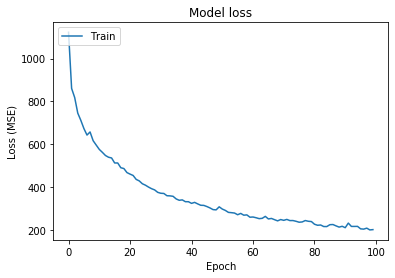

In [8]:
# Plot training & validation accuracy values
# plt.plot(model_history.history['mean_squared_error'])
# plt.title('Model MSE')
# plt.ylabel('MSE')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [9]:
# Testing
# ann_load = joblib.load('Saved_ANN_40_h_less_than_2.pkl')

pred = model.predict(test_X)
mse = mean_squared_error(test_Y, pred)
rmse_ann = np.sqrt(mse)
print(rmse_ann)

15.994465201422935


In [10]:
print(min(pred))
print(max(pred))

[0.6462879]
[596.6783]


Text(0.5, 1.0, 'Residuals')

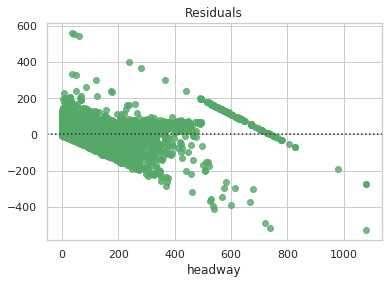

In [11]:
sns.set(style="whitegrid")

# Plot the residuals after fitting a linear model
sns.residplot(test_Y, pred, color="g").set_title('Residuals')

Residuals should not have a standard.

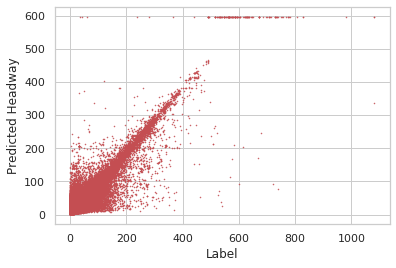

In [13]:
# Print all error to see if there is standard or some big outliers
plt.figure()
plt.plot(test_Y, pred, 'ro', ms=0.5)
plt.xlabel('Headway (Label)')
plt.ylabel('Predicted Headway')
plt.show()

NameError: name 'width' is not defined

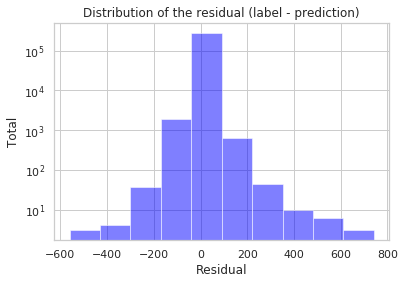

In [14]:
diff = test_Y - np.array(pred).flatten()
num_bins = 10
plt.hist(diff, num_bins, facecolor='blue', alpha=0.5, log=True)
plt.xlabel('Residual')
plt.ylabel('Total')
plt.title('Distribution of the residual (label - prediction)')
plt.rcParams["figure.figsize"] = (width,height) 
plt.show()

In [ ]:
model_history.history